In [98]:
while True:
    PRETRAINED = input(f'''Would you like to use the last saved trained model (p) or overwrite it with a new training session (train_new_model)?
p: pretrained, train_new_model: overwrite with new session''')
    if PRETRAINED == 'p':
        PRETRAINED = True
        break
    elif PRETRAINED == 'train_new_model':
        PRETRAINED = False
        break
    else:
        print("Invalid response. type p: pretrained, or train_new_model: overwrite with new session")

while True:
    COLAB = input(f'''Type (gc) if you are using Google Colab with GPU or (local) if you are running on your local machine's CPU.''')
    if COLAB == 'gc':
        COLAB = True
        break
    elif COLAB == 'local':
        COLAB = False
        break
    else:
        print("Invalid response. type gc: Google Colab, or local: local machine")

RANDOM_SEED = 42
RISK_LEVEL = 0.2 # (conservative) 0.0 to 1.0 (risky)
!pip install -r requirements.txt

In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
%matplotlib inline

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

path = './'
if COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    path = '/content/gdrive/My Drive/Transformer/'  


In [100]:
df = pd.read_csv(f"{path}data/stock_data.csv", sep=',')
df.shape

(5791, 2)

In [101]:
df.tail()

,Text,Sentiment
5786,Industry body CII said #discoms are likely to ...,-1
5787,"#Gold prices slip below Rs 46,000 as #investor...",-1
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1
5790,"#Sensex, #Nifty climb off day's highs, still u...",1


In [102]:
df.Sentiment.replace(-1,0,inplace=True)
df.tail()

,Text,Sentiment
5786,Industry body CII said #discoms are likely to ...,0
5787,"#Gold prices slip below Rs 46,000 as #investor...",0
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1
5790,"#Sensex, #Nifty climb off day's highs, still u...",1


In [103]:
class StockTweetsDataset(Dataset):

    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt')

        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)}


In [104]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((4632, 2), (579, 2), (580, 2))

In [105]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = StockTweetsDataset(tweets=df.Text.to_numpy(), targets=df.Sentiment.to_numpy(), tokenizer=tokenizer, max_len=max_len)
    return DataLoader(ds, batch_size=batch_size, num_workers=4)

In [106]:
BATCH_SIZE = 16
MAX_LEN = 80
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', return_dict=False)

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [107]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased', return_dict=False)
    self.dropout = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    output = self.dropout(output)
    return self.out(output)


In [108]:
class_names = ['bearish', 'bullish']

if not PRETRAINED:
    data = next(iter(train_data_loader))
    data.keys()
    print(data['input_ids'].shape)
    print(data['attention_mask'].shape)
    print(data['targets'].shape)
    model = SentimentClassifier(len(class_names))
    model = model.to(device)
    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    F.softmax(model(input_ids, attention_mask), dim=1)
    EPOCHS = 10
    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
    total_steps = len(train_data_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    loss_fn = nn.CrossEntropyLoss().to(device)


In [109]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)


In [110]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [111]:
PATH = 'twitter_sentiment_model.pth'

if not PRETRAINED:
    %%time
    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)
        train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
        print(f'Train loss {train_loss} accuracy {train_acc}')
        val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            device = torch.device("cuda")
            model.to(device)
            torch.save({
                'history': history,
                'epoch': EPOCHS,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, PATH)
            best_accuracy = val_acc
else:
    model = SentimentClassifier(len(class_names))
    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

    if COLAB:
        PATH = path + PATH
        device = torch.device('cuda')
        checkpoint = torch.load(PATH)
        model.to(device)
    else:
        device = torch.device('cpu')
        checkpoint = torch.load(PATH, map_location=device)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    history = checkpoint['history']

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(0.0, 1.0)

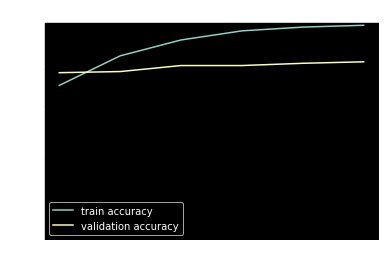

In [112]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

In [113]:
if not PRETRAINED:
    test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
    test_acc.item()

In [114]:
def get_predictions(model, data_loader):
    model = model.eval()
    tweets = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["tweet_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            probs = F.softmax(outputs, dim=1)
            tweets.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return tweets, predictions, prediction_probs, real_values

In [115]:
# This section is used to calculate predictions and save them to a .csv file
# or load them from the saved .csv file from the pretrained model.
if not PRETRAINED:
    y_tweets, y_pred, y_pred_probs, y_test = get_predictions(
        model, test_data_loader)
    y_pred_probs = torch.squeeze(y_pred_probs.reshape(-1, 1))
    y_pred_probs_bearish = y_pred_probs[:y_pred_probs.size(0)//2]
    y_pred_probs_bullish = y_pred_probs[y_pred_probs.size(0)//2:]
    outcome_df = pd.DataFrame({"y_tweets": y_tweets})
    outcome_df['y_pred'] = y_pred
    outcome_df['y_pred_probs_bearish'] = y_pred_probs_bearish
    outcome_df['y_pred_probs_bullish'] = y_pred_probs_bullish
    outcome_df['y_test'] = y_test
    outcome_df.to_csv(f"{path}twitter_sentiment_outcomes.csv")
else:
    outcome_df = pd.read_csv(f"{path}twitter_sentiment_outcomes.csv")
    y_tweets = outcome_df.y_tweets.tolist()
    y_pred = torch.tensor(outcome_df.y_pred.tolist())
    y_pred_probs_bearish = torch.tensor(
        outcome_df.y_pred_probs_bearish.to_list()).reshape(-1, 2)
    y_pred_probs_bullish = torch.tensor(
        outcome_df.y_pred_probs_bullish.tolist()).reshape(-1, 2)
    y_pred_probs = torch.cat((y_pred_probs_bearish, y_pred_probs_bullish), 0)
    y_test = torch.tensor(outcome_df.y_test.tolist())


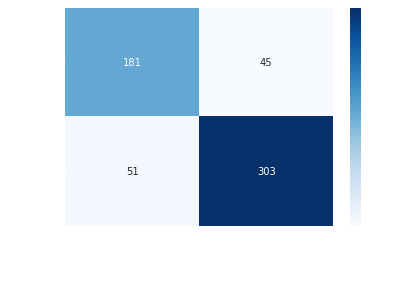

In [116]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [117]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     bearish       0.78      0.80      0.79       226
     bullish       0.87      0.86      0.86       354

    accuracy                           0.83       580
   macro avg       0.83      0.83      0.83       580
weighted avg       0.84      0.83      0.83       580



In [118]:
from tweepy import API
from tweepy import Cursor
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import re
import time
import api_credentials  # Update this file with your own Twitter and Alpaca credentials


class TwitterAuthenticator():
    '''
    Used to authenticate my Twitter Developer account for permission to use the Twitter API
    '''
    def authenticate_twitter_app(self):
        TWITTER_ACCESS_TOKEN = api_credentials.TWITTER_ACCESS_TOKEN
        TWITTER_ACCESS_TOKEN_SECRET = api_credentials.TWITTER_ACCESS_TOKEN_SECRET
        TWITTER_CONSUMER_KEY = api_credentials.TWITTER_CONSUMER_KEY
        TWITTER_CONSUMER_SECRET = api_credentials.TWITTER_CONSUMER_SECRET
        auth = OAuthHandler(TWITTER_CONSUMER_KEY, TWITTER_CONSUMER_SECRET)
        auth.set_access_token(TWITTER_ACCESS_TOKEN, TWITTER_ACCESS_TOKEN_SECRET)
        return auth


class TwitterClient():
    '''
    A class for connecting to the Twitter API
    '''
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)
        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client

    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets


class TwitterStreamer():
    """
    A class for streaming live tweets.
    """
    def __init__(self):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()

    def stream_tweets(self, hash_tag_list):
        listener = TwitterListener()
        stream = Stream(self.auth, listener)

        # Filter Twitter streams by keywords
        stream.filter(track=hash_tag_list)


class TwitterListener(StreamListener):
    '''
    An exponentially increasing time-out penalty is applied to a developer's account each time Twitter's request limit is exceeded.
    This listener will stop the program from running if it recieves an error code 420, 
    which is an indication that our program is about to exceed the tweet request limit.    
    
    A maximum of 450 recent search requests for tweets is allowed every 15 minutes.
    '''
    def on_error(self, status):
        if status == 420:
            # Return False on_data method in case rate limit occurs.
            return False
        print(status)


class TweetPreprocessor():

    def clean_tweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

    def tweets_to_data_frame(self, tweets):
        '''
        Returns the data frame of tweets and the latest tweet id, 
        so that the next function call will only include tweets after 
        the latest tweet id to avoid duplication.

        Input: tweepy.models.SearchResults (a JSON data structure of tweets)
        Outputs: a pandas data frame of recent tweets and the latest tweet id
        '''
        df = pd.DataFrame(data=[self.clean_tweet(tweet.text) for tweet in tweets], columns=['tweet'])

        df['id'] = np.array([tweet.id for tweet in tweets])

        # The lastest tweet id is conveiniently the largest number
        latest_id = df.id.max()

        # # If you want to drop retweets from data frame
        # df = df[~df.tweet.str.contains("RT")]

        return df, latest_id


In [119]:
def predict_live_tweets(model, df, risk_level=0.5):
    '''
    This function takes a data frame of tweets for a single ticker. 
    Each tweet's sentiment is predicted with a certainty equivalent to the 
    difference in probability scores for bullish and bearish sentiments.

    Tweets with relatively low certainty do not affect the polarity, which decides
    whether to buy or sell the stock. The level of certainty that determines if
    a sentiment prediction is worth acting on is determined by the user's predetermined 
    risk variable.

    Polarity increases by one with each certain bullish prediction and decreases by one 
    with each certain bearish prediction. A polarity score of 0 means do nothing. 
    The magnitude of the polarity score acts as a multiplier on the number of stock shares to trade.
    '''
    trade_bool = False
    polarity = 0
    min_certainty = 7 - (risk_level*4)
    predictions = []
    for tweet in df.tweet:
        encoded_tweet = tokenizer.encode_plus(tweet, max_length=MAX_LEN, add_special_tokens=True,
            return_token_type_ids=False, padding=True, return_attention_mask=True, return_tensors='pt')
        input_ids = encoded_tweet['input_ids'].to(device)
        attention_mask = encoded_tweet['attention_mask'].to(device)
        output = model(input_ids, attention_mask)
        max_score, prediction = torch.max(output, dim=1)
        predictions.append(prediction.item())
        min_score, _ = torch.min(output, dim=1)
        certainty = (max_score - min_score).item()
        if certainty >= min_certainty:
            if prediction.item() == 0:
                polarity -= 1
            else:
                polarity += 1
    if polarity > 0 or polarity < 0:
        trade_bool = True

    df['prediction'] = np.array(predictions)
    
    return polarity, trade_bool, df


In [120]:
'''This section is only to be used to automate cancelling all pending
orders that were made during code development outside of stock market hours'''

import alpaca_trade_api as tradeapi
import api_credentials

def cancel_pending_orders():
    ALPACA_ENDPOINT_URL = api_credentials.ALPACA_ENDPOINT_URL
    ALPACA_API_KEY = api_credentials.ALPACA_API_KEY
    ALPACA_SECRET_KEY = api_credentials.ALPACA_SECRET_KEY
    api = tradeapi.REST(ALPACA_API_KEY, ALPACA_SECRET_KEY,
                        ALPACA_ENDPOINT_URL, api_version='v2')

    orders = api.list_orders()
    if len(orders) > 0:
        for order in orders:
            api.cancel_order(order.id)

# cancel_pending_orders()


In [121]:
import alpaca_trade_api as tradeapi

unique_minutes = []

def alpaca_trader(ticker, polarity):
    global unique_minutes
    ALPACA_ENDPOINT_URL = api_credentials.ALPACA_ENDPOINT_URL
    ALPACA_API_KEY = api_credentials.ALPACA_API_KEY
    ALPACA_SECRET_KEY = api_credentials.ALPACA_SECRET_KEY
    api = tradeapi.REST(ALPACA_API_KEY, ALPACA_SECRET_KEY, ALPACA_ENDPOINT_URL, api_version='v2')
    account = api.get_account()
    market_clock = api.get_clock()
    minute = int(str(market_clock.timestamp)[14:16])
    frequency = 10 # minutes
    if minute < 2 and len(unique_minutes) == 6:
        unique_minutes = []
    with open('portfolio_performance.txt', 'a') as f:
        # Write to file every {frequency} minutes
        if minute % frequency == 0:
            if minute not in unique_minutes:
                unique_minutes.append(minute)
                f.write(f"Equity: {account.equity}, Time Stamp: {market_clock.timestamp} \n")


    barset = api.get_barset(ticker[1:], 'day', limit=1)
    open_price = barset[ticker[1:]][0].o
    close_price = barset[ticker[1:]][0].c
    approximate_price_per_share = (open_price + close_price)/2
    # Determine how many shares to buy based on the price of the stock.
    # Currently allowing for 1% of portfolio per trade.
    shares_per_polarity_point = (float(account.portfolio_value) * 0.01) // approximate_price_per_share

    with open('stock_trading_decisions.txt', 'a') as f:
        msg = f"Time Stamp: {market_clock.timestamp} \n"
        print(msg)
        f.write(msg)
        
        if market_clock.is_open:
            if polarity > 0:
                side = "buy"
                qty = polarity*shares_per_polarity_point
                expense = approximate_price_per_share * qty

                # If buying power is limited, then decrease quantity of shares until transaction amount is lower than buying power
                while expense > float(account.buying_power):
                    qty -= 1
                    expense = approximate_price_per_share * qty
            else:
                side = "sell"
                polarity *= -1
                qty = polarity*shares_per_polarity_point

                # Check how many shares I currently own, if any
                # try except because an error is thrown if zero shares are owned.
                try:
                    pos_qty = float(api.get_position(ticker[1:]).qty)
                except Exception as exception:
                    if exception.__str__() == 'position does not exist':
                        pos_qty = 0
                if qty > pos_qty:
                    qty = pos_qty

            # only perform a trade if trading more than 0 shares
            if qty > 0:
                # Sometimes the prices change and throw a buying power error. Decrease qty until satisfied.
                invalid = True
                skipped = False
                while invalid:
                    try:
                        if qty == 0:
                            skipped = True
                            break
                        # market: buy or sell at market price, opposed to a limit order.
                        # time_in_force: only keep order open until end of the day
                        order = api.submit_order(
                            symbol=ticker[1:], qty=qty, side=side, type="market", time_in_force="day")
                        invalid = False
                    except Exception as exception:
                        if exception.__str__() == 'insufficient buying power':
                            qty -= 1
                if not skipped:
                    if order.status == 'accepted':
                        msg = f"Success! Order placed to {order.side} {order.qty} shares of {ticker}. \n"
                        print(msg)
                        f.write(msg)
                    else:
                        msg = f"Trade failed. Alpaca account status: {account.status}. \n"
                        print(msg)
                        f.write(msg)
                else:
                    msg = f"Transaction prices changed during processing. Either not enough buying power or insufficent shares to sell. Skipping. \n"
                    print(msg)
                    f.write(msg)
                time.sleep(3)
            else:
                if side == "buy":
                    msg = f"You don't have enough buying power to buy {ticker}. Skipping. \n"
                    print(msg)
                else:
                    msg = f"You do not own any shares of {ticker} to sell. Skipping. \n"
                    print(msg)
            time.sleep(3)
        else:
            msg = f"No orders were made because the stock market is currently closed for trading. \n"
            print(msg)
        time.sleep(3)

In [122]:
def main():
    '''
    https://developer.twitter.com/en/docs/twitter-api/rate-limits

    I can make a maximum of 450 recent search requests for tweets every 15 minutes.
    Making more requests than this will result in an error.
    This works out to one request made every 2 seconds.

    To be safe, since time.sleep is approximate - I will pause for 5 seconds after tweet queries
    and 3 seconds after stock order queries, which is more than enough wait time.

    This means that a particular ticker, such as $AAPL, will be checked on every time.sleep(#) * len(hash_tag_list) seconds.
    '''
    twitter_client = TwitterClient()
    tweet_preprocessor = TweetPreprocessor()
    api = twitter_client.get_twitter_client_api()
    latest_id = None
    hash_tag_dict = {"$AAPL": None, "$ABNB": None, "$AMD": None, "$AMZN": None, "$BA": None, "$DIS": None,
                     "$FB": None, "$GOOGL": None, "$NFLX": None, "$NVDA": None, "$SPY": None, "$TSLA": None, "$VZ": None, "$XOM": None}
    while True:
        for ticker in hash_tag_dict.keys():
            print(f"Searching for recent tweets about {ticker}")
            tweets = api.search(q=ticker, lang='en', result_type='recent', since_id=hash_tag_dict[ticker])
            df, latest_id = tweet_preprocessor.tweets_to_data_frame(tweets)
            # update the value of the current ticker to the latest tweet id
            hash_tag_dict[ticker] = latest_id
            polarity, trade_bool, df = predict_live_tweets(model, df, risk_level=RISK_LEVEL)
            # ### useful print codes to illustrate what is happening:
            # print(df[['tweet', 'prediction']])  
            # print(df[['tweet', 'id']])
            print()

            if trade_bool:
                if polarity > 0:
                    print(f"Positive sentiment polarity score of {polarity}. Preparing to buy {ticker} stock.")
                else:
                    print(f"Negative sentiment polarity score of {polarity}. Preparing to sell {ticker} stock.")
                print()
                alpaca_trader(ticker, polarity)
            else:
                print(f"Neutral sentiment polarity score. Hold off on trading {ticker} stock.")
            time.sleep(5)  # seconds
            print()
            print('--------------------')
            print()
main()

Searching for recent tweets about $AAPL


TweepError: [{'code': 215, 'message': 'Bad Authentication data.'}]